In [ ]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [1]:
# Imports
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Iterable


import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [45]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(DQN, self).__init__()

        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        self.linear1 = nn.Linear(32*4*4, 128)
        self.linear2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear1(x))
        q_value = self.linear2(x)
        return q_value

In [46]:
class Duelling_DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(Duelling_DQN, self).__init__()

        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)

        self.linear = nn.Linear(32*6*6, 512)

        self.value = nn.Linear(512, 1)
        self.advantage = nn.Linear(512, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear(x))

        value = self.value(x)
        advantage = self.advantage(x)

        q_value = value + advantage - torch.sum(advantage)/self.action_num

        return q_value

In [47]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [48]:
def exponential_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    if current_timestep >= duration:
        return eps_end
    decay_rate = -math.log(eps_end / eps_start) / duration
    epsilon = eps_end + (eps_start - eps_end) * math.exp(-decay_rate * current_timestep)
    return epsilon

In [49]:
import math

def restarting_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int, restarts: int, exploit: int) -> float:
    interval = round(duration/restarts)
    if current_timestep >= duration:
        return eps_end
    ratio = min(1.0, ((current_timestep % interval) +  exploit) / (interval))
    lin_ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio)*(1-lin_ratio) + eps_end

In [50]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int) -> torch.Tensor:
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

In [51]:
class PrioritizedReplayBuffer:
    def __init__(self, max_size: int, obs_size):
        self.max_size = max_size
        self.obs = torch.empty(size = (max_size, obs_size[0], obs_size[1], obs_size[2]))
        self.act_rew_term = torch.zeros(size = (max_size,3))
        self.next_obs = torch.empty(size = (max_size, obs_size[0], obs_size[1], obs_size[2]))
        self.priorities = torch.zeros(max_size)
        self.probabilities = torch.zeros(max_size)
        self.probabilities[0] = 1
        self.position = 0
        self.max = 0

    def __len__(self) -> int:
        return len(self.data)

    def get_probabilities(self, alpha):
        scaled_priorities = torch.pow(self.priorities, alpha)
        if torch.sum(scaled_priorities) == 0:
            return torch.tensor([1])
        else:
           return scaled_priorities / torch.sum(scaled_priorities)

    def set_priorities(self, indices, errors, offset=0.05):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

    def get_importance(self, probabilities, beta):
        N_length = max(self.max, self.position)
        importance_weight = (1/N_length) * (1/probabilities)
        scaled_importance_weight = torch.pow(importance_weight, beta)
        max_weight = torch.max(scaled_importance_weight) #To normalize
        return (scaled_importance_weight / max_weight)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        self.obs[self.position] = obs
        self.act_rew_term[self.position,:] = torch.tensor([action, reward, terminated])
        self.next_obs[self.position] = next_obs
        self.priorities[self.position] = max(self.priorities[0:self.position], default=1)
        if (self.position + 1) % self.max_size == 0:
            self.max = self.max_size
        self.position = (self.position + 1) % self.max_size

    def update_probabilities(self, alpha):
        self.probabilities = self.get_probabilities(alpha)

    def sample(self, batch_size: int, alpha=1.0, beta=1.0) -> torch.Tensor:
        indexer = range(0,max(self.max, self.position))
        sample_indices = torch.tensor(random.choices(indexer, k=batch_size, weights=self.probabilities[0:max(self.max, self.position)].tolist()))
        selected_obs = self.obs[sample_indices]
        selected_nextobs = self.next_obs[sample_indices]
        act_rew_term = self.act_rew_term[sample_indices]
        importance = self.get_importance(self.probabilities[sample_indices], beta)
        return selected_obs, act_rew_term[:,0], act_rew_term[:,1], selected_nextobs, act_rew_term[:,2], sample_indices, importance

In [52]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    loss.backward()
    optimizer.step()


In [53]:
def update_ddqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

    q_val = q(obs).gather(1, act.type(torch.int64).unsqueeze(1))

    mseloss = F.mse_loss(q_val, td_target)
    mseloss.backward()
    optimizer.step()

In [54]:
def update_ddqn_per(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        importance_weights: torch.Tensor,
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

    q_val = q(obs).gather(1, act.type(torch.int64).unsqueeze(1))

    mseloss = F.mse_loss(q_val, td_target)
    importance_weights_mean = importance_weights.mean()
    weighted_loss = mseloss * importance_weights_mean

    weighted_loss.backward()
    optimizer.step()

    error_batch =  torch.sub(q_val, td_target)
    error_batch = error_batch.detach()

    return error_batch


In [61]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards", "run_time"])

class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        self.buffer = ReplayBuffer(maxlen)
        self.q = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        self.exploit_phase = 400
        self.restarts = 4

        for params in self.q_target.parameters():
            params.requires_grad = False


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
            run_time=np.zeros(num_episodes)
        )
        start = time.time()
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 10 == 0:
                print(f'DQN: Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                epsilon = restarting_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration, self.restarts, self.exploit_phase)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1
                
                stats.run_time[i_episode] = time.time() - start
                
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [62]:
class DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        self.buffer = ReplayBuffer(maxlen)
        self.q = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        self.exploit_phase = 400
        self.restarts = 4

        for params in self.q_target.parameters():
            params.requires_grad = False


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
            run_time=np.zeros(num_episodes)
        )
        start = time.time()
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 10 == 0:
                print(f'DDQN: Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = restarting_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration, self.restarts, self.exploit_phase)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1
                
                stats.run_time[i_episode] = time.time() - start

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [63]:
class Duelling_DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        self.buffer = ReplayBuffer(maxlen)
        self.q = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        self.exploit_phase = 400
        self.restarts = 4

        for params in self.q_target.parameters():
            params.requires_grad = False

    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
            run_time=np.zeros(num_episodes)
        )
        start = time.time()
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 10 == 0:
                print(f'Duelling_DDQN: Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = restarting_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration, self.restarts, self.exploit_phase)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1
                
                stats.run_time[i_episode] = time.time() - start

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [64]:
class Duelling_DDQN_PER_Agent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            alpha=1.0,
            beta=1.0,
            alpha_beta_start = 1.0,
            alpha_beta_end = 0.1,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.alpha = alpha
        self.beta = beta
        self.alpha_beta_start = alpha_beta_start
        self.alpha_beta_end = alpha_beta_end

        self.buffer = PrioritizedReplayBuffer(maxlen, env.observation_space.shape)
        self.q = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        self.exploit_phase = 400
        self.restarts = 4

        for params in self.q_target.parameters():
            params.requires_grad = False


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
            run_time=np.zeros(num_episodes)
        )
        start = time.time()
        current_timestep = 0

        epsilon = self.eps_start
        alpha = self.alpha
        beta = self.beta

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 10 == 0:
                print(f'Duelling_DDQN_PER: Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f} Alpha: {alpha:.3f} Beta: {beta:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():

                epsilon = restarting_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration, self.restarts, self.exploit_phase)
                alpha = exponential_decay(self.alpha_beta_start, self.alpha_beta_end, current_timestep, self.schedule_duration)
                beta = exponential_decay(self.alpha_beta_start, self.alpha_beta_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(int(terminated))
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch, sample_indices, importance = self.buffer.sample(self.batch_size, alpha, beta)

                # Update the Q network
                batch_errors = update_ddqn_per(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch,
                    importance
                )

                # Set prirority of experience based on errors returned from Update step
                self.buffer.set_priorities(sample_indices, batch_errors)
                self.buffer.update_probabilities(alpha)

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1
                
                stats.run_time[i_episode] = time.time() - start

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [68]:
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 30000
NUM_EPISODES = 200
DISCOUNT_FACTOR = 0.99
ALPHA = 1.0
BETA = 1.0
ALPHA_BETA_START = 1.0
ALPHA_BETA_END = 0.05

# Train DQN
agent_dqn = DQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats_dqn = agent_dqn.train(NUM_EPISODES)


# Train DDQN
agent_ddqn = DDQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats_ddqn = agent_ddqn.train(NUM_EPISODES)


# Train Duelling DDQN
agent_duelling_ddqn = Duelling_DDQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats_duelling_ddqn = agent_duelling_ddqn.train(NUM_EPISODES)

# Train Duelling DDQN With Priority Experience Replay (PER) Buffer
agent_duelling_ddqn_per = Duelling_DDQN_PER_Agent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    alpha = ALPHA,
    beta = BETA,
    alpha_beta_start = ALPHA_BETA_START,
    alpha_beta_end = ALPHA_BETA_END,

)
stats_duelling_ddqn_per = agent_duelling_ddqn_per.train(NUM_EPISODES)


Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)

DQN: Episode 10 of 200  Time Step: 366  Epsilon: 0.449
DQN: Episode 20 of 200  Time Step: 959  Epsilon: 0.407
DQN: Episode 30 of 200  Time Step: 1637  Epsilon: 0.360
DQN: Episode 40 of 200  Time Step: 2104  Epsilon: 0.329
DQN: Episode 50 of 200  Time Step: 2815  Epsilon: 0.283
DQN: Episode 60 of 200  Time Step: 3550  Epsilon: 0.238
DQN: Episode 70 of 200  Time Step: 4711  Epsilon: 0.171
DQN: Episode 80 of 200  Time Step: 5903  Epsilon: 0.108
DQN: Episode 90 of 200  Time Step: 7555  Epsilon: 0.366
DQN: Episode 100 of 200  Time Step: 8658  Epsilon: 0.304
DQN: Episode 110 of 200  Time Step: 9463  Epsilon: 0.261
DQN: Episode 120 of 200  Time Step: 11263  Epsilon: 0.175
DQN: Episode 130 of 200  Time Step: 12859  Epsilon: 0.110
DQN: Episode 140 of 200  Time Step: 14651  Epsilon: 0.050
DQN: Episode 150 of 200  Time Step: 15962  Epsilon: 0.222
DQN: Episode 160 of 200  Time Ste

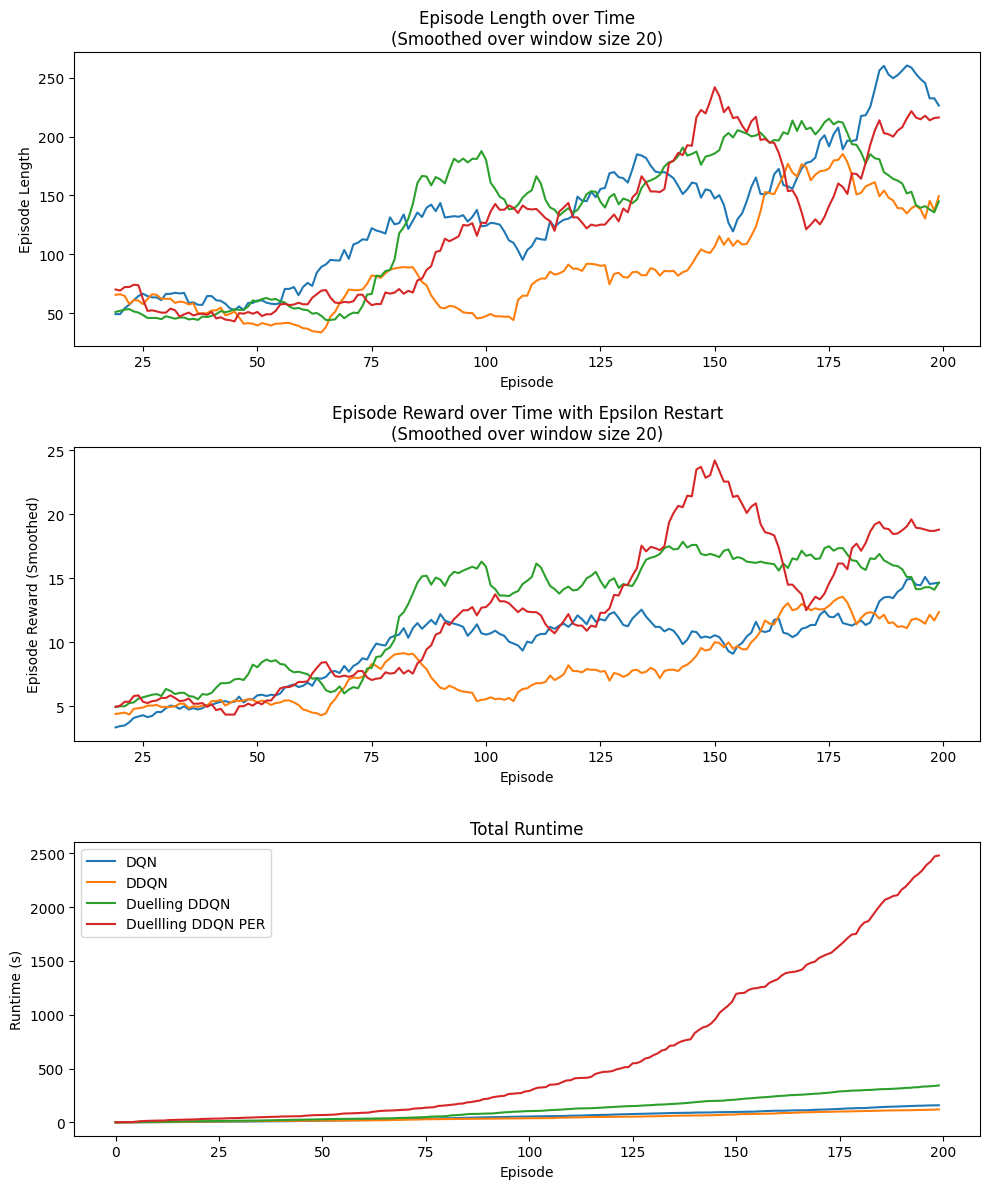

In [69]:
smoothing_window=20 #1
fig, axes = plt.subplots(3, 1, figsize=(10, 12), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
lengths_smoothed_dqn = pd.Series(stats_dqn.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed_ddqn = pd.Series(stats_ddqn.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed_duelling_ddqn = pd.Series(stats_duelling_ddqn.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed_duelling_ddqn_per = pd.Series(stats_duelling_ddqn_per.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax.plot(lengths_smoothed_dqn, label="DQN")
ax.plot(lengths_smoothed_ddqn, label="DDQN")
ax.plot(lengths_smoothed_duelling_ddqn, label="Duelling DDQN")
ax.plot(lengths_smoothed_duelling_ddqn_per, label="Duelling DDQN PER")

ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title(f"Episode Length over Time\n(Smoothed over window size {smoothing_window})")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed_dqn = pd.Series(stats_dqn.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed_ddqn = pd.Series(stats_ddqn.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed_duelling_ddqn = pd.Series(stats_duelling_ddqn.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed_duelling_ddqn_per = pd.Series(stats_duelling_ddqn_per.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax.plot(rewards_smoothed_dqn, label="DQN")
ax.plot(rewards_smoothed_ddqn, label="DDQN")
ax.plot(rewards_smoothed_duelling_ddqn, label="Duelling DDQN")
ax.plot(rewards_smoothed_duelling_ddqn_per, label="Duelling DDQN PER")

ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time with Epsilon Restart\n(Smoothed over window size {smoothing_window})")

ax = axes[2]
ax.plot(stats_dqn.run_time, label = "DQN")
ax.plot(stats_ddqn.run_time, label = "DDQN")
ax.plot(stats_duelling_ddqn.run_time, label = "Duelling DDQN")
ax.plot(stats_duelling_ddqn_per.run_time, label = "Duellling DDQN PER")
ax.set_xlabel("Episode")
ax.set_ylabel("Runtime (s)")
ax.set_title(f"Total Runtime")

plt.legend()
plt.show()